### Initial package imports

In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import Dict, List
import random
from matplotlib.gridspec import GridSpec

# Validation files

In [2]:
validation_set_closing_prices = pd.read_csv('Data/a5/data used/valid data/stocks.csv', sep=',')
display(validation_set_closing_prices.tail())
currency_validation_set = pd.read_csv('Data/a5/data used/origin data/closing_prices_native_currency.csv', sep=';')
currency_validation_df = currency_validation_set[['Date', 'USD/EUR', 'JPY/EUR']]
display(currency_validation_df.tail())
validation_set_closing_prices['Date'] = pd.to_datetime(validation_set_closing_prices['Date'], format='%Y/%m/%d')
# validation_set_closing_prices.set_index('Date', inplace=True)

,Date,AAPL(USD),MSFT(USD),ASML.AS(EUR),6758.T(JPY),VOW3.DE(EUR)
2342,2020/3/27,60.121304,143.289627,219.024734,1317.343506,64.657967
2343,2020/3/30,61.837044,153.368713,233.578674,1267.312866,64.412636
2344,2020/3/31,61.710838,150.956650,231.383636,1264.752197,65.528908
2345,2020/4/1,58.463799,145.596451,223.796509,1226.736572,60.720348
2346,2020/4/2,59.439365,148.611572,219.072433,1245.251953,60.616077


,Date,USD/EUR,JPY/EUR
3121,NaN,0.88306,0.007712
3122,NaN,0.88261,0.007723
3123,NaN,0.88380,0.007685
3124,NaN,0.88027,0.007698
3125,NaN,NaN,0.007655


In [4]:
# Create log returns for validation set
# For AAPL and MSFT (USD)
validation_set_closing_prices['AAPL_Returns'] = np.log(validation_set_closing_prices['AAPL(USD)']) - np.log(validation_set_closing_prices['AAPL(USD)'].shift(1))
validation_set_closing_prices['MSFT_Returns'] = np.log(validation_set_closing_prices['MSFT(USD)']) - np.log(validation_set_closing_prices['MSFT(USD)'].shift(1))

# For ASML.AS and VOW3.DE (EUR)
validation_set_closing_prices['ASML_Returns'] = np.log(validation_set_closing_prices['ASML.AS(EUR)']) - np.log(validation_set_closing_prices['ASML.AS(EUR)'].shift(1))
validation_set_closing_prices['VOW3_Returns'] = np.log(validation_set_closing_prices['VOW3.DE(EUR)']) - np.log(validation_set_closing_prices['VOW3.DE(EUR)'].shift(1))

# For 6758.T (JPY)
validation_set_closing_prices['Sony_Returns'] = np.log(validation_set_closing_prices['6758.T(JPY)']) - np.log(validation_set_closing_prices['6758.T(JPY)'].shift(1))

validation_set_closing_prices['Return_USD/EUR'] = np.log(currency_validation_df['USD/EUR']) - np.log(currency_validation_df['USD/EUR'].shift(1))
validation_set_closing_prices['Return_JPY/EUR'] = np.log(currency_validation_df['JPY/EUR']) - np.log(currency_validation_df['JPY/EUR'].shift(1))

# Corrected returns
validation_set_closing_prices['C_AAPL_Returns'] = validation_set_closing_prices['AAPL_Returns'] - validation_set_closing_prices['Return_USD/EUR']
validation_set_closing_prices['C_MSFT_Returns'] = validation_set_closing_prices['MSFT_Returns'] - validation_set_closing_prices['Return_USD/EUR']
validation_set_closing_prices['C_ASML_Returns'] = validation_set_closing_prices['ASML_Returns']
validation_set_closing_prices['C_VOW3_Returns'] = validation_set_closing_prices['VOW3_Returns'] 
validation_set_closing_prices['C_Sony_Returns'] = validation_set_closing_prices['Sony_Returns'] - validation_set_closing_prices['Return_JPY/EUR']

display(validation_set_closing_prices.tail())


,Date,AAPL(USD),MSFT(USD),ASML.AS(EUR),6758.T(JPY),VOW3.DE(EUR),AAPL_Returns,MSFT_Returns,ASML_Returns,VOW3_Returns,Sony_Returns,Return_USD/EUR,Return_JPY/EUR,C_AAPL_Returns,C_MSFT_Returns,C_ASML_Returns,C_VOW3_Returns,C_Sony_Returns
2342,2020-03-27,60.121304,143.289627,219.024734,1317.343506,64.657967,-0.042284,-0.041928,-0.081550,-0.075611,0.044017,-0.000778,-0.003165,-0.041506,-0.041150,-0.081550,-0.075611,0.047182
2343,2020-03-30,61.837044,153.368713,233.578674,1267.312866,64.412636,0.028138,0.067977,0.064334,-0.003802,-0.038718,-0.004632,0.004428,0.032771,0.072609,0.064334,-0.003802,-0.043146
2344,2020-03-31,61.710838,150.956650,231.383636,1264.752197,65.528908,-0.002043,-0.015852,-0.009442,0.017182,-0.002023,0.002732,0.001892,-0.004775,-0.018584,-0.009442,0.017182,-0.003914
2345,2020-04-01,58.463799,145.596451,223.796509,1226.736572,60.720348,-0.054052,-0.036154,-0.033340,-0.076213,-0.030519,0.012608,0.001888,-0.066660,-0.048762,-0.033340,-0.076213,-0.032407
2346,2020-04-02,59.439365,148.611572,219.072433,1245.251953,60.616077,0.016549,0.020497,-0.021335,-0.001719,0.014980,-0.006427,0.033025,0.022976,0.026924,-0.021335,-0.001719,-0.018045


In [5]:
weights_validation = {
    'AAPL': 0.2,
    'MSFT': 0.2,
    'ASML.AS': 0.2,
    'VOW3.DE': 0.2,
    '6758.T': 0.2
}

initial_validation_investment = 1000000  # 1 million euros
equity_validation_investment = 600000
loan_validation_investment = 400000

starting_date = '06/04/2010'

starting_row_val = currency_validation_df[currency_validation_df['Date'] == starting_date]

validation_USD_TO_EUR = float(starting_row_val['USD/EUR'].iloc[0])
validation_JPY_TO_EUR = float(starting_row_val['JPY/EUR'].iloc[0])


loan_validation_set = pd.read_csv('Data/a5/data used/valid data/euribor_daily_rates.csv', sep=';')

#replace all the commas with dots
loan_validation_set = loan_validation_set.replace(',', '.', regex=True)
loan_validation_set['3m'] = pd.to_numeric(loan_validation_set['3m'])

year = 360
credit_spread = 0.015

# Calculate daily rate for each row
loan_validation_set['Daily_rate'] = ((loan_validation_set['3m'] / 100) + credit_spread) / year

validation_set_closing_prices['Loan_expenses'] = loan_validation_set['Daily_rate'].iloc[0] * loan_validation_investment

# Set initial investments for first row (index 0)

validation_set_closing_prices = (
    validation_set_closing_prices
    .reset_index(drop=True)    # make the index 0,1,2,...
)


validation_set_closing_prices.loc[0, 'AAPL_Investment'] = initial_validation_investment * weights_validation['AAPL']
validation_set_closing_prices.loc[0, 'MSFT_Investment'] = initial_validation_investment * weights_validation['MSFT']
validation_set_closing_prices.loc[0, 'ASML_Investment'] = initial_validation_investment * weights_validation['ASML.AS']
validation_set_closing_prices.loc[0, 'VOW3_Investment'] = initial_validation_investment * weights_validation['VOW3.DE']
validation_set_closing_prices.loc[0, 'Sony_Investment'] = initial_validation_investment * weights_validation['6758.T']


for i in range(1, len(validation_set_closing_prices)):
    validation_set_closing_prices.loc[i, 'AAPL_Investment'] = \
    validation_set_closing_prices.loc[i-1, 'AAPL_Investment'] \
    * np.exp(validation_set_closing_prices.loc[i, 'C_AAPL_Returns'])
    validation_set_closing_prices.loc[i, 'MSFT_Investment'] = \
    validation_set_closing_prices.loc[i-1, 'MSFT_Investment'] \
    * np.exp(validation_set_closing_prices.loc[i, 'C_MSFT_Returns'])
    validation_set_closing_prices.loc[i, 'ASML_Investment'] = \
    validation_set_closing_prices.loc[i-1, 'ASML_Investment'] \
    * np.exp(validation_set_closing_prices.loc[i, 'C_ASML_Returns'])
    validation_set_closing_prices.loc[i, 'VOW3_Investment'] = \
    validation_set_closing_prices.loc[i-1, 'VOW3_Investment'] \
    * np.exp(validation_set_closing_prices.loc[i, 'C_VOW3_Returns'])
    validation_set_closing_prices.loc[i, 'Sony_Investment'] = \
    validation_set_closing_prices.loc[i-1, 'Sony_Investment'] \
    * np.exp(validation_set_closing_prices.loc[i, 'C_Sony_Returns'])

 
# build portfolio daily log‐return
validation_set_closing_prices['r_portfolio'] = (
      weights_validation['AAPL']    * validation_set_closing_prices['C_AAPL_Returns']
    + weights_validation['MSFT']    * validation_set_closing_prices['C_MSFT_Returns']
    + weights_validation['ASML.AS'] * validation_set_closing_prices['C_ASML_Returns']
    + weights_validation['VOW3.DE'] * validation_set_closing_prices['C_VOW3_Returns']
    + weights_validation['6758.T']  * validation_set_closing_prices['C_Sony_Returns']
)

# 1) make sure the columns exist (as floats) before your loop
validation_set_closing_prices['Total_investment'] = np.nan
validation_set_closing_prices['Total_investment_loan_correction'] = np.nan

# 2) set your initial values at row 0
validation_set_closing_prices.loc[0, 'Total_investment'] = initial_validation_investment
validation_set_closing_prices.loc[0, 'Total_investment_loan_correction'] = (
    initial_validation_investment - validation_set_closing_prices.loc[0, 'Loan_expenses']
)

# 3) now your loop will work without KeyErrors
for i in range(1, len(validation_set_closing_prices)):
    prev_val = validation_set_closing_prices.loc[i-1, 'Total_investment']
    r       = validation_set_closing_prices.loc[i,   'r_portfolio']
    new_val  = prev_val * np.exp(r)
    validation_set_closing_prices.loc[i, 'Total_investment'] = new_val

for i in range(1, len(validation_set_closing_prices)):
    # subtract that day’s loan expense
    prev_val = validation_set_closing_prices.loc[i-1, 'Total_investment_loan_correction']
    r = validation_set_closing_prices.loc[i, 'r_portfolio']
    exp = validation_set_closing_prices.loc[i, 'Loan_expenses']
    corrected_val = prev_val * np.exp(r) - exp
    validation_set_closing_prices.loc[i, 'Total_investment_loan_correction'] = corrected_val

# cols=['Total_investment', 'Total_investment_loan_correction']
# validation_set_closing_prices[cols].tail()



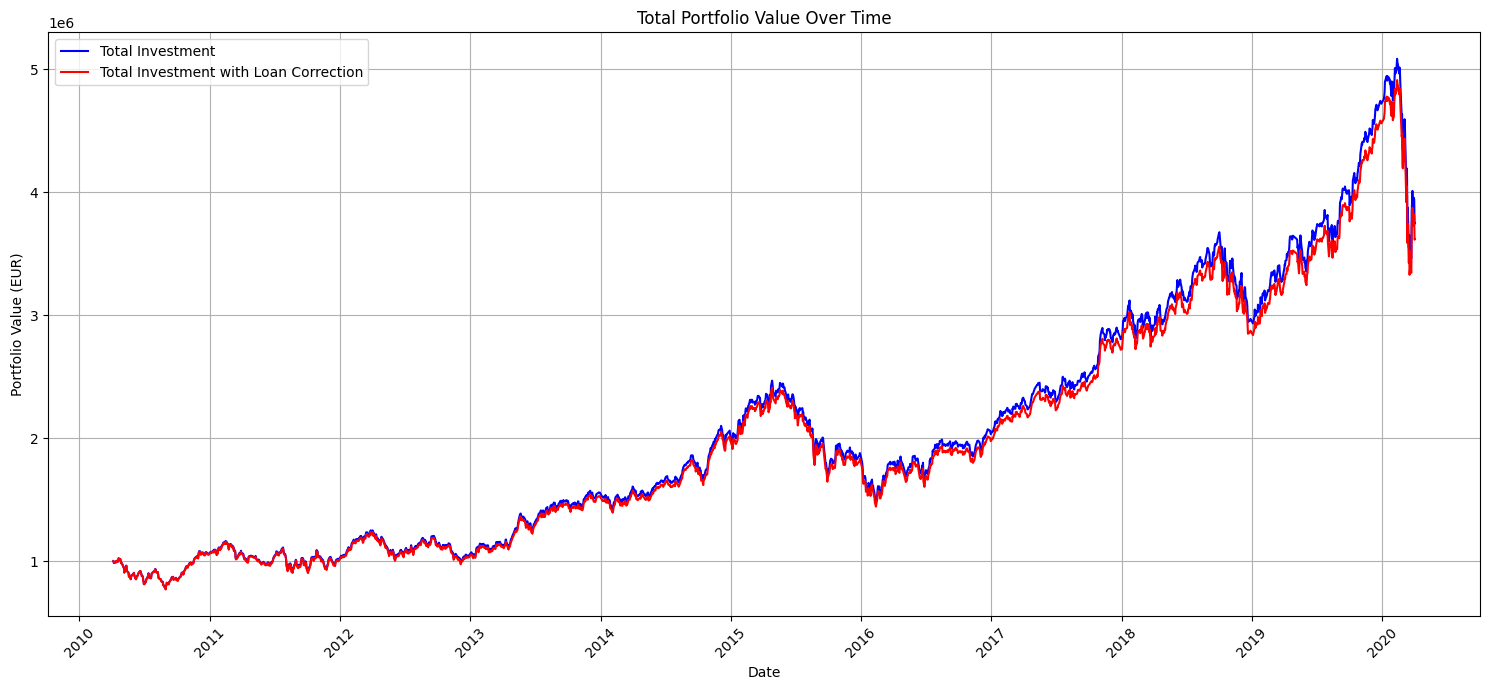

In [6]:
#plot the total portfolio returns over time
plt.figure(figsize=(15, 7))
plt.plot(validation_set_closing_prices['Date'], validation_set_closing_prices['Total_investment'], label='Total Investment', color='blue')
plt.plot(validation_set_closing_prices['Date'], validation_set_closing_prices['Total_investment_loan_correction'], label='Total Investment with Loan Correction', color='red')
plt.title('Total Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (EUR)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [7]:

#Calculate the loss per day per asset which is the difference between the investment of the previous day and the current day
validation_set_closing_prices['AAPL_Loss'] = validation_set_closing_prices['Total_investment'] * weights_validation['AAPL'] * validation_set_closing_prices['C_AAPL_Returns'] * -1
validation_set_closing_prices['MSFT_Loss'] = validation_set_closing_prices['Total_investment'] * weights_validation['MSFT'] * validation_set_closing_prices['C_MSFT_Returns'] * -1
validation_set_closing_prices['ASML_Loss'] = validation_set_closing_prices['Total_investment'] * weights_validation['ASML.AS'] * validation_set_closing_prices['C_ASML_Returns'] * -1
validation_set_closing_prices['VOW3_Loss'] = validation_set_closing_prices['Total_investment'] * weights_validation['VOW3.DE'] * validation_set_closing_prices['C_VOW3_Returns'] *-1
validation_set_closing_prices['Sony_Loss'] = validation_set_closing_prices['Total_investment'] * weights_validation['6758.T'] * validation_set_closing_prices['C_Sony_Returns'] *-1

validation_set_closing_prices['MSFT_Loss_loan_correction'] = validation_set_closing_prices['Total_investment_loan_correction'] * weights_validation['MSFT'] * validation_set_closing_prices['C_MSFT_Returns'] *-1
validation_set_closing_prices['AAPL_Loss_loan_correction'] = validation_set_closing_prices['Total_investment_loan_correction'] * weights_validation['AAPL'] * validation_set_closing_prices['C_AAPL_Returns'] *-1
validation_set_closing_prices['ASML_Loss_loan_correction'] = validation_set_closing_prices['Total_investment_loan_correction'] * weights_validation['ASML.AS'] * validation_set_closing_prices['C_ASML_Returns'] *-1
validation_set_closing_prices['VOW3_Loss_loan_correction'] = validation_set_closing_prices['Total_investment_loan_correction'] * weights_validation['VOW3.DE'] * validation_set_closing_prices['C_VOW3_Returns'] *-1
validation_set_closing_prices['Sony_Loss_loan_correction'] = validation_set_closing_prices['Total_investment_loan_correction'] * weights_validation['6758.T'] * validation_set_closing_prices['C_Sony_Returns'] *-1

#calculate the total loss per day
validation_set_closing_prices['Portfolio_Loss'] = (validation_set_closing_prices['AAPL_Loss'] + validation_set_closing_prices['MSFT_Loss'] + validation_set_closing_prices['ASML_Loss'] + validation_set_closing_prices['VOW3_Loss'] + validation_set_closing_prices['Sony_Loss']+ validation_set_closing_prices['Loan_expenses'])
validation_set_closing_prices['Portfolio_Loss_loan_correction'] = (validation_set_closing_prices['AAPL_Loss_loan_correction'] + validation_set_closing_prices['MSFT_Loss_loan_correction'] + validation_set_closing_prices['ASML_Loss_loan_correction'] + validation_set_closing_prices['VOW3_Loss_loan_correction'] + validation_set_closing_prices['Sony_Loss_loan_correction']+ validation_set_closing_prices['Loan_expenses'])

# Calculate the total portfolio value and return
validation_set_closing_prices['Total_Portfolio_Return'] = (validation_set_closing_prices['Total_investment'].pct_change(fill_method=None))
validation_set_closing_prices['Total_Portfolio_Return'] = validation_set_closing_prices['Total_Portfolio_Return'].fillna(0)

validation_set_closing_prices['Total_Portfolio_Return_loan_correction'] = (validation_set_closing_prices['Total_investment_loan_correction'].pct_change(fill_method=None))
validation_set_closing_prices['Total_Portfolio_Return_loan_correction'] = validation_set_closing_prices['Total_Portfolio_Return_loan_correction'].fillna(0)

display(validation_set_closing_prices.tail(10))

,Date,AAPL(USD),MSFT(USD),ASML.AS(EUR),6758.T(JPY),VOW3.DE(EUR),AAPL_Returns,MSFT_Returns,ASML_Returns,VOW3_Returns,...,Sony_Loss,MSFT_Loss_loan_correction,AAPL_Loss_loan_correction,ASML_Loss_loan_correction,VOW3_Loss_loan_correction,Sony_Loss_loan_correction,Portfolio_Loss,Portfolio_Loss_loan_correction,Total_Portfolio_Return,Total_Portfolio_Return_loan_correction
2337,2020-03-19,59.402966,136.598984,191.873276,1167.842407,53.875504,-0.007692,0.016319,0.078345,0.007313,...,11034.446232,-6039.357118,10150.757618,-52826.141414,-4930.716430,10658.263063,-44480.670835,-42963.438725,0.012832,0.012825
2338,2020-03-23,54.449886,130.157165,203.755051,1155.432983,56.580326,-0.087063,-0.048307,0.060083,0.048985,...,13458.488251,30482.581678,56405.467695,-40187.650507,-32764.611156,12999.572999,27909.997331,26959.116264,-0.008022,-0.008029
2339,2020-03-24,59.912598,141.987900,229.045502,1220.827637,67.356644,0.095606,0.086999,0.117002,0.174340,...,-39257.714676,-65413.103907,-71809.796026,-86956.819213,-129570.880517,-37918.840200,-405475.121430,-391645.684308,0.111155,0.111148
2340,2020-03-25,59.582546,140.628693,233.721802,1280.312866,70.460129,-0.005524,-0.009619,0.020211,0.045045,...,-39150.825292,10881.953894,7783.143128,-15295.286917,-34089.776509,-37815.358846,-70931.925604,-68511.569695,0.018277,0.018271
2341,2020-03-26,62.717968,149.425186,237.634689,1260.615723,69.736404,0.051285,0.060673,0.016603,-0.010325,...,10512.354650,-51747.948900,-44474.912031,-12863.317407,7998.985593,10153.707429,-94121.664124,-90909.729761,0.023752,0.023745
2342,2020-03-27,60.121304,143.289627,219.024734,1317.343506,64.657967,-0.042284,-0.041928,-0.081550,-0.075611,...,-36415.089269,30676.330003,30941.594811,60793.019876,56365.858806,-35172.501142,148701.367889,143628.057909,-0.037794,-0.037801
2343,2020-03-30,61.837044,153.368713,233.578674,1267.312866,64.412636,0.028138,0.067977,0.064334,-0.003802,...,34128.332703,-55473.286738,-25036.754954,-49151.120517,2904.331549,32963.570328,-97083.674313,-93769.504777,0.024857,0.024851
2344,2020-03-31,61.710838,150.956650,231.383636,1264.752197,65.528908,-0.002043,-0.015852,-0.009442,0.017182,...,3084.066143,14142.524903,3633.567999,7185.368795,-13075.378529,2978.791768,15413.974503,14888.630492,-0.003899,-0.003905
2345,2020-04-01,58.463799,145.596451,223.796509,1226.736572,60.720348,-0.054052,-0.036154,-0.033340,-0.076213,...,24252.472007,35246.506360,48183.542463,24098.896865,55088.272380,23424.461660,192641.656246,186065.435284,-0.050174,-0.050180
2346,2020-04-02,59.439365,148.611572,219.072433,1245.251953,60.616077,0.016549,0.020497,-0.021335,-0.001719,...,13527.947997,-19495.412498,-16636.507213,15448.365816,1244.505108,13066.000855,-6574.610844,-6349.292377,0.001762,0.001755


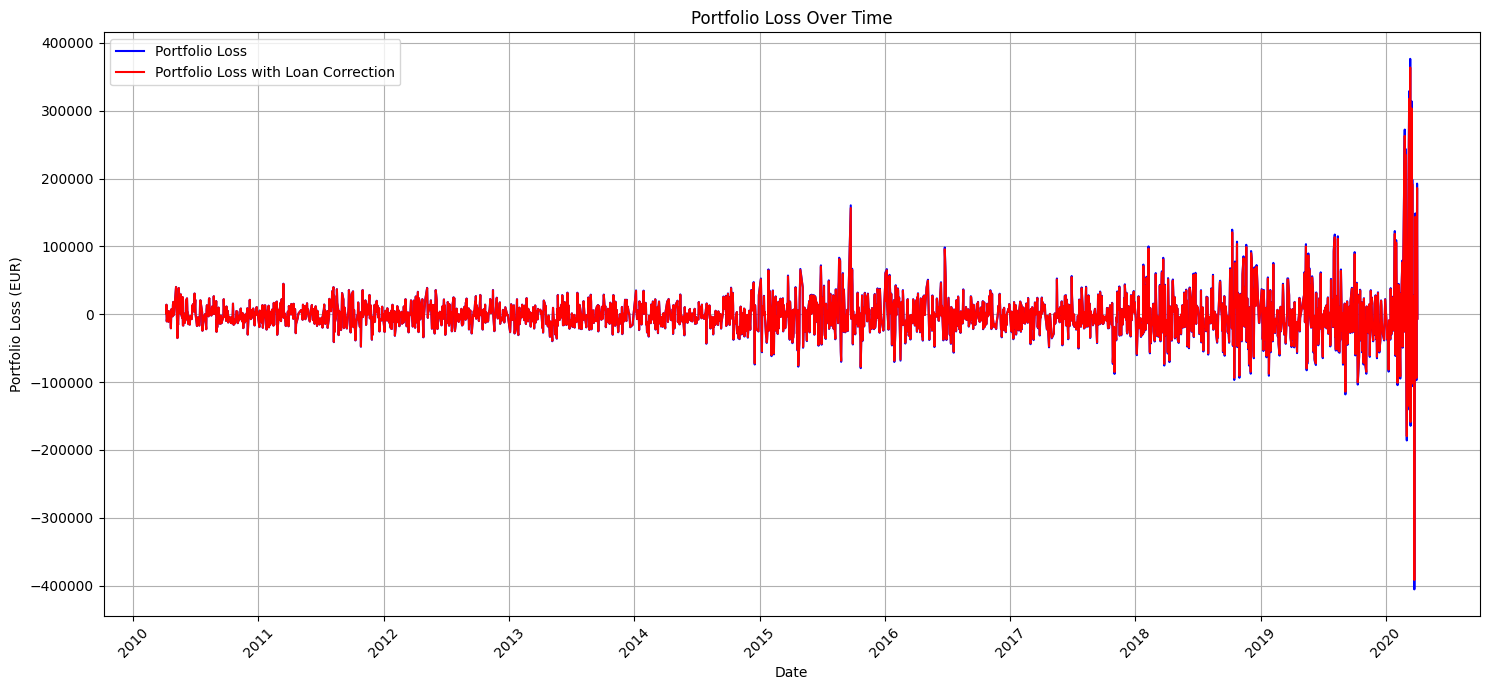

In [8]:
#make a plot with the portfolio loss and portfolio loss loan correction
plt.figure(figsize=(15, 7))
plt.plot(validation_set_closing_prices['Date'], validation_set_closing_prices['Portfolio_Loss'], label='Portfolio Loss', color='blue')
plt.plot(validation_set_closing_prices['Date'], validation_set_closing_prices['Portfolio_Loss_loan_correction'], label='Portfolio Loss with Loan Correction', color='red')
plt.title('Portfolio Loss Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Loss (EUR)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Methods input values 

### Portfolio change Daily

In [9]:
# Replace instances of main_df with validation_set_closing_prices
if 'Portfolio_Daily_Returns' not in validation_set_closing_prices.columns:
    # Calculate the daily returns from existing return columns
    validation_set_closing_prices['Portfolio_Daily_Returns'] = (
        0.2 * validation_set_closing_prices['C_AAPL_Returns'] +
        0.2 * validation_set_closing_prices['C_MSFT_Returns'] +
        0.2 * validation_set_closing_prices['C_ASML_Returns'] +
        0.2 * validation_set_closing_prices['C_VOW3_Returns'] +
        0.2 * validation_set_closing_prices['C_Sony_Returns']
    )

In [10]:
def calculate_daily_loss_variables(time_window, current_date):
    # Calculate the mean and standard deviation of portfolio loss from the time windows
    loss_dict = {
        "Date": current_date,
        "Portfolio_mean_loss": np.nanmean(time_window['Portfolio_Loss_loan_correction']),
        "Portfolio_std_loss": np.nanstd(time_window['Portfolio_Loss_loan_correction'])
    }
    return loss_dict

In [11]:
returns_df = validation_set_closing_prices[['Date', 'C_AAPL_Returns', 'C_MSFT_Returns', 
                                            'C_ASML_Returns', 'C_VOW3_Returns', 'C_Sony_Returns']].dropna()
# set Date as index
returns_df.set_index('Date', inplace=True)

# var_df, es_df = rolling_fhs_multiday_var_es(
#     returns_df,
#     weights_validation,
#     window_size=250,
#     horizons=[1],
#     confidence_levels=[0.95, 0.99],
#     n_simulations=10000,
#     lambdas=[0.94, 0.97],
#     random_seed=42
# )

# # Calculate monetary values for VaR and ES
# monetary_var_df, monetary_es_df = calculate_monetary_values(var_df, es_df, validation_set_closing_prices)
# # Display the monetary VaR and ES DataFrames
# display(monetary_var_df.tail())
# display(monetary_es_df.tail())